# Data Analysis Part Andrea

Linking number of edit events since last successful build to probability of build succeeding

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Import cleaned Data


In [3]:
#if cleaned csv available
editEvents = pd.read_csv("data/df_edit.csv")
buildEvents = pd.read_csv("data/df_build.csv")
# else run script ()
#def parse_timestamp(time):
#    if type(time) is str:
#        time = time.split('.')[0]
#        return pd.Timestamp(time)
#buildEvents['timestamp']=buildEvents['timestamp'].apply(parse_timestamp)
#editEvents['timestamp']=editEvents['timestamp'].apply(parse_timestamp)

### Edit Events

In [4]:
print(f'No of edit events: {len(editEvents)}')
editEvents.tail()

No of edit events: 497459


,Unnamed: 0,sessionID,timestamp
497454,258848,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:48
497455,258849,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:52
497456,258850,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:58
497457,258851,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:14:03
497458,258852,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:14:07


In [8]:
editEvents[["sessionID","timestamp"]].describe()

,sessionID,timestamp
count,497459,497459
unique,2876,488049
top,8d0ea603-57cd-4b1f-b3cf-ce39ec9203c7,2016-09-04 23:28:09
freq,17006,4


### Build Events

In [5]:
print(f'No of build events: {len(buildEvents)}')
buildEvents.head()

No of build events: 14957


,Unnamed: 0,sessionID,timestamp,buildSuccessful
0,14061,0,2016-10-04 14:35:55,False
1,14062,0,2016-10-04 14:36:07,False
2,14063,0,2016-10-04 14:36:50,False
3,14064,0,2016-10-04 14:36:53,False
4,14065,1,2016-10-04 14:37:03,True


In [11]:
buildEvents[["sessionID","timestamp","buildSuccessful"]].describe()

,sessionID,timestamp,buildSuccessful
count,14957,14956,14956
unique,1531,14877,2
top,26f3dadd-c2e3-414b-8c92-78df1dc356c8,2016-04-21 17:41:37,True
freq,154,2,12889


In [6]:
print(f'{round(12889/14956*100)}% are successful Build event')

86% are successful Build event


# Process Data

1. Step: For each sessionID:
    - a) get timestamp of the last successfull build
    - b) get timestamp of next build after a)
2. Step: For each session ID:
    - Count number of edit between the two timestamp in Step 1
    - if no buildEvent after last successfull build occurs, dont count
3. Step: Create new DataFrame with following variables:
    - sessionID,timestampSuccessBuild, timestampNextBuild, #editsUntilNextBuild and nextBuildResult

In [7]:
def get_all_build(sessionID):
    all_build = buildEvents[buildEvents["sessionID"] == sessionID]
    return all_build.sort_values(["timestamp"]).values


In [8]:
def get_successful_build(sessionID):
    all_successful_build = buildEvents[(buildEvents["sessionID"] == sessionID) & (buildEvents["buildSuccessful"] == True)] 
    return all_successful_build.sort_values(["timestamp"]).values


In [9]:
def get_nr_edits_between_build(sessionID,timeLastSuccessfullBuild, timeNextBuild):
    totalEdit = editEvents[editEvents["sessionID"] == sessionID]
    totalEdit = totalEdit.sort_values(["timestamp"])
    editBetweenSuccessBuildAndBuild = totalEdit[(totalEdit["timestamp"] <= timeNextBuild) & (totalEdit["timestamp"] >= timeLastSuccessfullBuild)]
    return editBetweenSuccessBuildAndBuild["timestamp"].values.size


In [10]:
def edits_from_pass_to_next_build(sessionID):
    result = []

    # get all successful build of session 
    allSuccessfulBuild = get_successful_build(sessionID)
    allBuild = get_all_build(sessionID)
    numOfSuccessfulBuild = np.size(allSuccessfulBuild,0)
    numOfBuild = np.size(allBuild,0)
    # iterate over each passed build
    for s in range(numOfSuccessfulBuild):
        # if build follows, count edits
        if allBuild[-1][2]>allSuccessfulBuild[s][2]:
            for b in range(numOfBuild):
                if allBuild[b][2]>allSuccessfulBuild[s][2]:
                    break
            timeLastSuccessfulBuild=allSuccessfulBuild[s][2]
            timeNextBuild=allBuild[b][2]
            resultNextBuild=allBuild[b][3]
            nrOfEdit=get_nr_edits_between_build(sessionID,timeLastSuccessfulBuild, timeNextBuild)
            sessionID = allBuild[b][1]
            time_passed = pd.Timedelta(datetime.strptime(timeNextBuild, '%Y-%m-%d %H:%M:%S')-datetime.strptime(timeLastSuccessfulBuild, '%Y-%m-%d %H:%M:%S')).seconds
            
            result.append([sessionID, timeLastSuccessfulBuild, timeNextBuild, time_passed, nrOfEdit, resultNextBuild])
            
    return result

### Iterate over all sessions and create DataFrame

In [11]:
final_result=[]
allSessionID=buildEvents.sessionID.unique()
print(f'time before loop: {datetime.now(tz=None)} \n')
# get edits_from_pass_to_next_build for all sessionID
for sessionID in allSessionID:
    Observations = edits_from_pass_to_next_build(sessionID)
    NrOfObservations = len(Observations)
    # take only sessionID with at least 1 successful build and at least 1 build after that  
    if NrOfObservations > 0:
        for Obs in Observations:
            final_result.append(Obs)
print(f'time after loop: {datetime.now(tz=None)} \n')

time before loop: 2020-05-12 17:07:32.456794 

time after loop: 2020-05-12 17:13:50.756424 



In [12]:
#create DataFrame
column_labels = ['sessionID','timestampSuccessBuild','timestampNextBuild','time_passed', '#editsUntilNextBuild', 'nextBuildResult']
df = pd.DataFrame(final_result, columns=column_labels)
df

,sessionID,timestampSuccessBuild,timestampNextBuild,time_passed,#editsUntilNextBuild,nextBuildResult
0,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 09:27:01,2016-11-10 10:22:32,3331,5,True
1,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 10:22:32,2016-11-10 10:58:26,2154,16,True
2,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 10:58:26,2016-11-10 11:07:58,572,18,True
3,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 11:07:58,2016-11-10 11:37:53,1795,38,True
4,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 11:37:53,2016-11-10 11:41:29,216,8,True
...,...,...,...,...,...,...
11584,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:53:44,2016-06-14 14:57:24,220,6,True
11585,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:57:24,2016-06-14 15:04:17,413,39,True
11586,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:04:17,2016-06-14 15:05:05,48,3,True
11587,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:05:05,2016-06-14 15:23:53,1128,43,True


## Build a Model

In [13]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
import statsmodels.tools.tools as sm
import statsmodels.api as sm1
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE

In [14]:
df.isnull().any()

sessionID                False
timestampSuccessBuild    False
timestampNextBuild       False
time_passed              False
#editsUntilNextBuild     False
nextBuildResult          False
dtype: bool

#### Data exploration

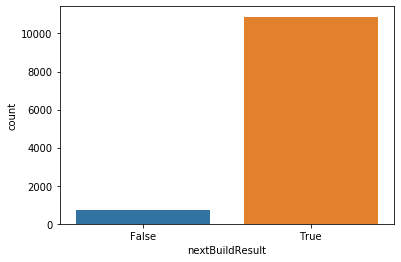

only 6.1% of the build-events fail


In [61]:
sns.countplot(x="nextBuildResult",data=df)
plt.show()
count_failedBuild = len(df[df["nextBuildResult"]==False])
count_passedBuild = len(df[df["nextBuildResult"]==True])
pct_failedBuild = round(count_failedBuild/(count_failedBuild+count_passedBuild)*100,1)
print(f'only {pct_failedBuild}% of the build-events fail')

In [15]:
df.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","max"]})

#editsUntilNextBuild                 
                               count       mean   max
nextBuildResult                                      
False                            710  43.074648  3838
True                           10879  18.572663  2330

* Our classes (successful vs. fail Build events) are strongly imbalanced.
* The average number of edits between the last successful Build and the next Build event is more then twice as much for fail Build as for successful Build. This seems to support our hypothesis.

Let's do some more exploration

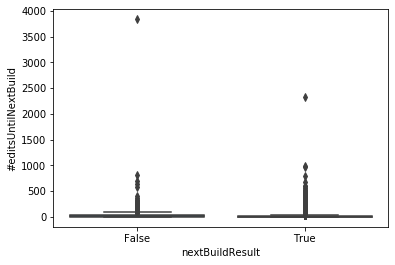

In [62]:
sns.boxplot(x=df["nextBuildResult"], y=df["#editsUntilNextBuild"])

There might be outlier in the dataset. We might want to keep only observation with at most **200? 75?** edits between Build event

In [18]:
df1=df.loc[(df["#editsUntilNextBuild"]>0) & (df["#editsUntilNextBuild"]<200)]
df1.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","max"]})

#editsUntilNextBuild                
                               count       mean  max
nextBuildResult                                     
False                            686  27.360058  198
True                           10755  15.428266  199

In [67]:
df2=df.loc[(df["#editsUntilNextBuild"]>0) & (df["#editsUntilNextBuild"]<75)]
df2.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","max"]})

#editsUntilNextBuild               
                               count       mean max
nextBuildResult                                    
False                            621  17.175523  73
True                           10411  12.137931  74

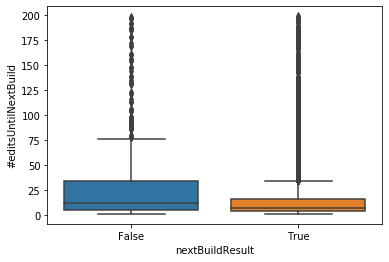

In [20]:
sns.boxplot(x=df1["nextBuildResult"], y=df1["#editsUntilNextBuild"])

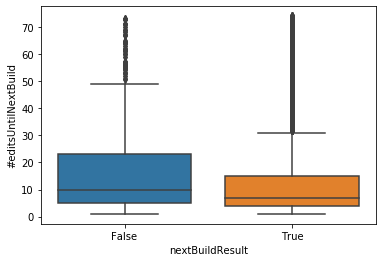

In [21]:
sns.boxplot(x=df2["nextBuildResult"], y=df2["#editsUntilNextBuild"])

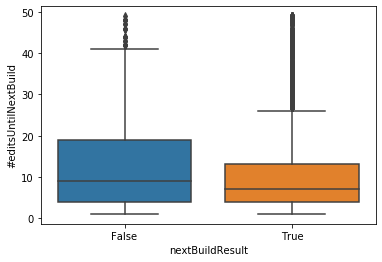

In [70]:
sns.boxplot(x=df3["nextBuildResult"], y=df3["#editsUntilNextBuild"])

In [72]:
print(f'{round(len(df2)/len(df)*100,1)}% of all observation has a number of edits between Build events lower than 75')

95.2% of all observation has a number of edits between Build events lower than 75


(0, 100)

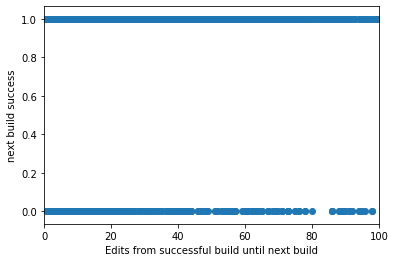

In [58]:
plt.scatter(df["#editsUntilNextBuild"],df["nextBuildResult"])
plt.xlabel("Edits from successful build until next build")
plt.ylabel("next build success")
plt.xlim(0,100)

### Classification Model

#### Logistic Model

Goal: predict the probability of the categorical dependent variable (i.e. success or failure of the Build-Event). \
The logistic regression predicts P(Y=success) as a function of X (nr. of edits). 

In [75]:
Y = df1["nextBuildResult"]
X = df1[["#editsUntilNextBuild",'time_passed']]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.222037
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        nextBuildResult   No. Observations:                11441
Model:                          Logit   Df Residuals:                    11438
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 May 2020   Pseudo R-squ.:                 0.02124
Time:                        22:25:12   Log-Likelihood:                -2540.3
converged:                       True   LL-Null:                       -2595.5
Covariance Type:            nonrobust   LLR p-value:                 1.131e-24
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.0045      0.048     62.861      0.000       2.911       3.098

The coefficient of 'time_passed' is not statistical significant (at 90% significant level) and therefore we will remove it. 

In [76]:
Y = df1["nextBuildResult"]
X = df1["#editsUntilNextBuild"]
X1 = sm.add_constant(X)
logit_model = sm1.Logit(Y, X1)
result_logit_model = logit_model.fit()
print(result_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.222142
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        nextBuildResult   No. Observations:                11441
Model:                          Logit   Df Residuals:                    11439
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 May 2020   Pseudo R-squ.:                 0.02078
Time:                        22:28:32   Log-Likelihood:                -2541.5
converged:                       True   LL-Null:                       -2595.5
Covariance Type:            nonrobust   LLR p-value:                 2.859e-25
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.0014      0.048     62.898      0.000       2.908       3.095

As we saw in the data exploration part. Our dataset is strong imbalanced. Let's try to balance the dataset!   

In [89]:
os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X1, Y, test_size=0.1,random_state=0)

os_data_X, os_data_Y = os.fit_sample(X_train,Y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=['constant','#editsUntilNextBuild'])
os_data_Y = pd.DataFrame(data=os_data_Y, columns=['nextBuildResult'])

print("length of oversampled data is", len(os_data_X))
print("Number of failed Build in oversampled data", len(os_data_Y[os_data_Y['nextBuildResult']==False]))
print("Number of successful Build", len(os_data_Y[os_data_Y['nextBuildResult']==True]))
print("Proportion of failed Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==False])/len(os_data_X))
print("Proportion of successful Build in oversampled data is",len(os_data_Y[os_data_Y['nextBuildResult']==True])/len(os_data_X))

logit_model=sm1.Logit(os_data_Y,os_data_X)
result_logit=logit_model.fit()
print(result_logit.summary2())

length of oversampled data is 19384
Number of failed Build in oversampled data 9692
Number of successful Build 9692
Proportion of failed Build in oversampled data is 0.5
Proportion of successful Build in oversampled data is 0.5
Optimization terminated successfully.
         Current function value: 0.675030
         Iterations 5
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.026      
Dependent Variable:  nextBuildResult   AIC:               26173.5645 
Date:                2020-05-12 23:00  BIC:               26189.3089 
No. Observations:    19384             Log-Likelihood:    -13085.    
Df Model:            1                 LL-Null:           -13436.    
Df Residuals:        19382             LLR p-value:       9.1481e-155
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      5.0000                                          
--------------------------------------------------------------------

In [91]:
#Y = df1["nextBuildResult"]
#X = df1[["#editsUntilNextBuild",'time_passed']].values
#X_train, X_test, y_train, y_test = model_selection.train_test_split(os_data_X.values, os_data_Y, test_size=0.1,random_state=0)
#X_test=sm.add_constant(X_test)
logit_model=linear_model.LogisticRegression()
logit_model.fit(os_data_X, os_data_Y.values)

print('Accurancy of logistic regression classifier on test set:{:.2f}'.format(logit_model.score(X_test,Y_test)))

Accurancy of logistic regression classifier on test set:0.76


In [92]:
Y_pred = logit_model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(Y_test,Y_pred)
print(confusion_matrix)
print(metrics.classification_report(Y_test,Y_pred))

[[ 34  48]
 [224 839]]
             precision    recall  f1-score   support

      False       0.13      0.41      0.20        82
       True       0.95      0.79      0.86      1063

avg / total       0.89      0.76      0.81      1145



The coefficient for the nr. of edits is statistical significant and the number of edits seems to have a negative effect on the probability of a successful build. However the Pseudo R-squared of this logistical regression is very small. This leads us to think that there might be other (omitted) variables that have a much greater influence on the probability of successful build events.